In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output
import os
import random
import itertools

In [57]:
from prophet import Prophet
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from sklego.preprocessing import RepeatingBasisFunction

date_column

In [3]:
def date_column(x):
    y = x['year']
    m = x['month']
    return pd.Timestamp(y, m, 1)

def date_column_2(x):
    y = x['year']
    m = x['month']
    if y in [2016,2017,2018,2019]:
        return pd.Timestamp(y + 1, m, 1)
    else:
        return pd.Timestamp(y, m, 1)

In [315]:
train = pd.read_csv(r"New_train.csv")
test = pd.read_csv(r"Test.csv")

### Feature engineering

In [316]:
train['ds'] = train.apply(func = date_column, axis=1)
test['ds'] = test.apply(func = date_column, axis=1)
#train['ds'] = train.apply(func = date_column_2, axis=1)

**New features**
- sellin median
- product_lifecycle_stage

In [317]:
new_train_list = []
sku_groups = train.groupby(by = 'sku_name')
for sku_name, group in sku_groups:
    group.loc[:,'sellin_median'] = np.median(train[train.sku_name == sku_name].sellin)
    if len(new_train_list)==0:
        new_train_list = [group.copy()]
    else:
        new_train_list.append(group.copy())
train = pd.concat(new_train_list).reset_index(drop=True)

In [318]:
new_test_list = []
sku_groups = test.groupby(by = 'sku_name')
for sku_name, group in sku_groups:
    try:
        max_date = max(train[train.sku_name == sku_name].ds)
        index = train[(train.sku_name == sku_name) & (train.ds == max_date)].index
        group.loc[:,'product_lifecycle_stage'] = train.loc[index, 'product_lifecycle_stage'].item()
        group.loc[:,'sellin_median'] = np.median(train[train.sku_name == sku_name].sellin)
    except:
        group.loc[:,'product_lifecycle_stage'] = 'U'
        group.loc[:,'sellin_median'] = 30000
    if len(new_test_list)==0:
        new_test_list = [group.copy()]
    else:
        new_test_list.append(group.copy())
test = pd.concat(new_test_list).reset_index(drop=True)

- sellout general trend

In [319]:
temp = pd.DataFrame()
for sku_name in test.sku_name.unique():
    sku_temp =  train[train.sku_name == sku_name]
    if sku_temp.shape[0]>=40:
        temp = pd.concat([temp, sku_temp])
temp['y'] = temp['sellout']
prophet = Prophet(yearly_seasonality=3, daily_seasonality=False, weekly_seasonality=False, seasonality_mode = 'multiplicative', n_changepoints = 0)
prophet.fit(temp)
future = prophet.make_future_dataframe(periods=4, freq = 'MS')
forecast = prophet.predict(future)
serie = forecast['yhat']
index = forecast['ds']
a = [1]+[serie[i+1]/serie[i] for i in range(0, len(serie)-1)]
coefs_for_next_observs = pd.Series(data=a, index = index)

C:\Users\egand\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\egand\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\egand\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [320]:
train_sku_groups = train.groupby(by = 'sku_name')
cum_coefs_by_sku={}
new_train_list = []

for sku_name, group in train_sku_groups:
    
    #выясняем min date и sellout этой даты, если он равен 0 ты ищем дальше, так как если использовать 0 то все последующие значения будут тоже нулевые
    #если sellout отличный от нуля найти не получилось, то пусть будут везде нули. Хорошо.
    min_date = min(group.ds).asm8.astype('datetime64[M]')
    elem = group[group.ds == min_date].sellout.item()
    if elem == 0:
        other_dates = group.ds[1:]
        for date in other_dates:
            if group[group.ds == date].sellout.item() != 0:
                min_date = date
                elem = group[group.ds == date].sellout.item()
                break
    
    cumulative_coefs =  np.cumprod(coefs_for_next_observs[min_date:])
    cumulative_coefs[0] = 1
    for idx, row in group.iterrows():
        if row['ds']<min_date:
            group.loc[idx,'sellout_general_trend'] = 0
        else:
            group.loc[idx,'sellout_general_trend'] = elem * cumulative_coefs[row['ds']]
        
    cum_coefs_by_sku[sku_name] = (elem, cumulative_coefs)
    if len(new_train_list)==0:
        new_train_list = [group.copy()]
    else:
        new_train_list.append(group.copy())
train = pd.concat(new_train_list).reset_index(drop=True)


test_sku_groups = test.groupby(by = 'sku_name')
new_test_list = []
for sku_name, group in test_sku_groups:
    try: 
        elem, cumulative_coefs = cum_coefs_by_sku[sku_name]
        for idx, row in group.iterrows():
            group.loc[idx,'sellout_general_trend'] = elem * cumulative_coefs[row['ds']]
    except:
        for idx, row in group.iterrows():
            group.loc[idx,'sellout_general_trend'] = 0
    if len(new_test_list)==0:
        new_test_list = [group.copy()]
    else:
        new_test_list.append(group.copy())
test = pd.concat(new_test_list).reset_index(drop=True)

RFB

In [282]:
rbf = RepeatingBasisFunction(n_periods=12,
                             #remainder='passthrough',
                             column='month',
                             input_range=(1,12))
rbf.fit(train)
rfb_columns = [f'month_rfb_{i}' for i in range(12)]
rfb_train = pd.DataFrame(index=train.index, data=rbf.transform(train), columns = rfb_columns)
train = pd.concat([train,rfb_train],axis=1)

rfb_test = pd.DataFrame(index=test.index, data=rbf.transform(test), columns = rfb_columns)
test = pd.concat([test,rfb_test],axis=1)

In [321]:
test.head()

,sku_name,month,year,CAT_GENDER_BOTH,CAT_GENDER_MEN,CAT_GENDER_WOMEN,ds,product_lifecycle_stage,sellin_median,sellout_general_trend
0,ABEAHAMASHL,11,2021,0,0,1,2021-11-01,W,252237.0,101202.583856
1,ABEAHAMASHL,12,2021,0,0,1,2021-12-01,W,252237.0,115292.731368
2,ABEAHAMASHL,1,2022,0,0,1,2022-01-01,W,252237.0,67958.969958
3,ABEAHAMASHL,2,2022,0,0,1,2022-02-01,W,252237.0,25758.615822
4,ABEENNEARMAZZ,11,2021,0,0,1,2021-11-01,W,219821.0,10650.961414


### catboost

**Попытка 1**
- Добавить product_lifecycle_stage (дополнить тестовые записи последним lifecycle_stage из трейна)

In [ ]:
features = ['CAT_GENDER_BOTH','CAT_GENDER_MEN','CAT_GENDER_WOMEN','month','year','product_lifecycle_stage']
cat_cols = ['CAT_GENDER_BOTH','CAT_GENDER_MEN','CAT_GENDER_WOMEN','month','year','product_lifecycle_stage']

Результаты:
- Ошибка на кросс валидации 185-190к
- Ошибка на тесте 233к

**Попытка 2**
- Добавить product_lifecycle_stage (дополнить тестовые записи последним lifecycle_stage из трейна)
- Добавить sellin_median (медианы товаров)

In [ ]:
features = ['CAT_GENDER_BOTH','CAT_GENDER_MEN','CAT_GENDER_WOMEN','month','year','product_lifecycle_stage','sellin_median']
cat_cols = ['CAT_GENDER_BOTH','CAT_GENDER_MEN','CAT_GENDER_WOMEN','month','year','product_lifecycle_stage']

Результаты:
- модель: lr 0.1, n_est 1000, l2 1, depth 10
- Ошибка на кросс валидации 125-140к
- Ошибка на тесте 174к (172к если взять модуль предсказаний)

**Попытка 3**
- Добавить product_lifecycle_stage (дополнить тестовые записи последним lifecycle_stage из трейна)
- Добавить sellin_median (медианы товаров)
- Закодировать month radial basis functions (RFB)

In [ ]:
features =['CAT_GENDER_BOTH','CAT_GENDER_MEN','CAT_GENDER_WOMEN','year','month','product_lifecycle_stage','sellin_median'] + rfb_columns
cat_cols = ['CAT_GENDER_BOTH','CAT_GENDER_MEN','CAT_GENDER_WOMEN','year','month','product_lifecycle_stage']

Результаты:
- модель: n_estimators = 1000, lr=0.1, l2 = 6, depth = 8
- Ошибка на кросс валидации 125-135к
- Ошибка на тесте 199k

**Попытка 4**
- Добавить product_lifecycle_stage (дополнить тестовые записи последним lifecycle_stage из трейна)
- Добавить sellin_median (медианы товаров)
- Добавить общий тренд sellout постороенный на тестовых товарах Prophet

In [ ]:
features = ['CAT_GENDER_BOTH','CAT_GENDER_MEN','CAT_GENDER_WOMEN','month','year','product_lifecycle_stage','sellin_median','sellout_general_trend']
cat_cols = ['CAT_GENDER_BOTH','CAT_GENDER_MEN','CAT_GENDER_WOMEN','month','year','product_lifecycle_stage']

Результаты:
- Ошибка на кросс валидации 130-135к
- Ошибка на тесте 182к

**Попытка 5**
- Попытка 2 + но убрать признаки отвечюащие за пол, так как они всегда очень неважные

In [301]:
features = ['month','year','product_lifecycle_stage','sellin_median']
cat_cols = ['month','year','product_lifecycle_stage']

Результаты: (МЕГА УСПЕХ)
- Ошибка на кросс валидации 130-135к
- Ошибка на тесте 164к

**Попытка 6**
- Попытка 4 + но убрать признаки отвечюащие за пол, так как они всегда очень неважные

In [322]:
features = ['month','year','product_lifecycle_stage','sellin_median','sellout_general_trend']
cat_cols = ['month','year','product_lifecycle_stage']

In [324]:
y_train = train['sellin']
x = train.drop(columns = 'sellin')

In [305]:
model = CatBoostRegressor(early_stopping_rounds=250,
                          grow_policy = 'Depthwise',
                          loss_function='MAE',
                          cat_features= cat_cols,
                          verbose=False)
params = {'l2_leaf_reg':[1,3,6],
          'learning_rate': [0.1, 0.25, 0.5],
          'depth':[8,10],
          'n_estimators':range(500, 1001, 250)
         }

In [306]:
grid_search_res = model.grid_search(params, x[features], y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 140793.6355
bestIteration = 499

0:	loss: 140793.6355326	best: 140793.6355326 (0)	total: 1m 8s	remaining: 1h 20m 31s

bestTest = 135959.6283
bestIteration = 499

1:	loss: 135959.6282818	best: 135959.6282818 (1)	total: 2m 38s	remaining: 1h 32m 38s

bestTest = 135875.0782
bestIteration = 460

2:	loss: 135875.0782435	best: 135875.0782435 (2)	total: 3m 58s	remaining: 1h 31m 18s

bestTest = 135285.9629
bestIteration = 489

3:	loss: 135285.9629423	best: 135285.9629423 (3)	total: 5m 23s	remaining: 1h 31m 43s

bestTest = 140871.9358
bestIteration = 499

4:	loss: 140871.9357622	best: 135285.9629423 (3)	total: 6m 27s	remaining: 1h 26m 28s

bestTest = 136027.5699
bestIteration = 499

5:	loss: 136027.5698598	best: 135285.9629423 (3)	total: 7m 44s	remaining: 1h 25m 14s

bestTest = 135378.18
bestIteration = 495

6:	loss: 135378.1800409	best: 135285.9629423 (3)	total: 9m 15s	remaining: 1h 25m 55s

bestTest = 134371.4164
bestIteration = 470

7:	loss: 134371.4163915	best: 134371.4163915 (7)

In [307]:
grid_search_res['params']

{'depth': 10, 'l2_leaf_reg': 1, 'iterations': 1000, 'learning_rate': 0.1}

In [325]:
model_ = CatBoostRegressor(early_stopping_rounds=250,
                           depth=10,
                           n_estimators = 1000,
                           learning_rate = 0.1,
                           l2_leaf_reg = 1,
                          grow_policy = 'Depthwise',
                          loss_function='MAE',
                          cat_features= cat_cols,
                          verbose=False)
model_.fit(x[features], y_train)

Text(0, 0.5, 'Mean decrease in impurity')

<Figure size 720x360 with 0 Axes>

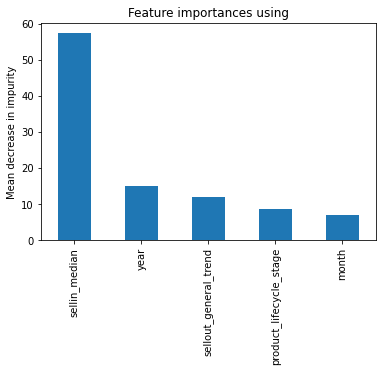

In [326]:
importances = model_.feature_importances_

feature_importances = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
fig, ax = plt.subplots()
feature_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using")
ax.set_ylabel("Mean decrease in impurity")

In [327]:
test['pred'] = abs(model_.predict(test[features]))

In [328]:
lst = []
columns=["Item_ID", "Target"]
for idx, row in test.iterrows():
    lst.append([row['sku_name']+'_'+str(row['month'])+'_'+str(row['year']), row['pred']])
sub = pd.DataFrame(data=lst, columns = columns)

In [329]:
sub.to_csv(os.getcwd()+'\submission 66 (abs preds); catboost = n_estimators = 1000, lr=0.1, l2 = 1, depth = 10; cv mae = 130-140k; features = lifecycle_stage, month, year, sellin_median, sellout_general_trend.csv',index=False)

In [147]:
sub

,Item_ID,Target
0,ABEAHAMASHL_11_2021,3487.064547
1,ABEAHAMASHL_12_2021,3297.387774
2,ABEAHAMASHL_1_2022,241968.045160
3,ABEAHAMASHL_2_2022,180558.550050
4,ABEENNEARMAZZ_11_2021,5718.152812
...,...,...
1523,YOSHRENECARL_2_2022,505140.033411
1524,YOSHTLYNYOSHZZ_11_2021,81550.275482
1525,YOSHTLYNYOSHZZ_12_2021,139101.721854
1526,YOSHTLYNYOSHZZ_1_2022,329320.922006
